# Pairs Trading Strategy using Mean Reversion

## Objectives


1. Scrape and pull stock symbols from the S&P500
2. Load historical stock data for the symbols scraped.
3. Carry out cointegration tests in order to form a suitable pair for trading.
4. Backtest strategy to visualize profits and losses. 

# Pairs Trading

Pairs trading is one of the popular mean reversion strategies. The idea is to trade on a pair of related stocks with near identical statistical/economical properties. We first estabilish a relationship between a pair of stocks using their historical data. The next step is to buy a security while simulatenously selling a secruity in order to maintain the original relationship discovered initially. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import alphavantage
import requests
import bs4 as bs
import yfinance as yf
import statistics


In [16]:
from pandas_datareader import data as pdr
import datetime
from statsmodels.tsa.stattools import coint, adfuller


In [17]:
def scrape_new_ticker():
    tickers = []
    industried = []
    data = requests.get('https://www.investopedia.com/ask/answers/08/find-stocks-in-sp500.asp')
    soup = bs.BeautifulSoup(data.text,'lxml')
    table = soup.find("ol",class_= "comp mntl-sc-block finance-sc-block-html mntl-sc-block-html")
    x = table.findAll('li')
    for row in x:
        s = row.find('a').text
        tickers.append(s.strip())
    tickers = list(map(lambda s : s.strip(),tickers))
    df_1 = pd.DataFrame(tickers,columns=["Ticker"])
    return tickers

        
symbols = scrape_new_ticker()



#the symbol of Berkshire-Hathway has changed, from BRK.B to BRK-B
symbols = ['BRK-B' if x == 'BRK.B' else x for x in symbols]
print(symbols)

#we have now obtained the list of the top 25 companies in the S&P500. 

['MSFT', 'AAPL', 'AMZN', 'TSLA', 'GOOGL', 'GOOG', 'FB', 'NVDA', 'BRK-B', 'JPM', 'HD', 'JNJ', 'UNH', 'PG', 'BAC', 'V', 'ADBE', 'NFLX', 'CRM', 'PFE', 'DIS', 'MA', 'XOM', 'TMO', 'COST']


The method presented below utilizes the AlphaVantage API to obtain price values for the ticker symbols obtained from the web scrape. 

Alphavantage Query requires passing the ticker symbol in order to obtain it's Daily pricing over a period of time. One of the caveats of the free API is that a maximum of 5 API calls are permitted every minute. In many instances, the querying times-out, which leads to the price table being rendered incomplete.

A simple workaround this limitation involves a sleep(10) added after every API calls, which ensures that the API call limit is not reached. However this adds an unecessary increase in the time to procure the stock prices. 

Pandas DataFrame offers a simple solution to the API limitation. Using Yfinance, one can simply pass the get_data_yahoo function to the list of stock symbols and obtain the closing prices over a specified period of time. 

In [18]:
start = datetime.datetime(2018, 1, 28)
end = datetime.datetime(2022, 1, 28)
prices = pdr.get_data_yahoo(symbols, start, end)['Close']
prices.head()


Symbols,MSFT,AAPL,AMZN,TSLA,GOOGL,GOOG,FB,NVDA,BRK-B,JPM,...,V,ADBE,NFLX,CRM,PFE,DIS,MA,XOM,TMO,COST
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-29,93.919998,41.990002,1417.680054,69.905998,1186.479980,1175.579956,185.979996,61.712502,215.460007,116.199997,...,124.839996,198.229996,284.589996,113.300003,37.020874,111.540001,168.550003,88.010002,218.809998,198.320007
2018-01-30,92.739998,41.742500,1437.819946,69.164001,1177.369995,1163.689941,187.119995,60.680000,214.410004,115.110001,...,123.550003,196.899994,278.799988,112.230003,35.863377,110.110001,167.190002,86.779999,214.619995,197.910004
2018-01-31,95.010002,41.857498,1450.890015,70.862000,1182.219971,1169.939941,186.889999,61.450001,214.380005,115.669998,...,124.230003,199.759995,270.299988,113.910004,35.142315,108.669998,169.000000,87.300003,224.110001,194.869995
2018-02-01,94.260002,41.945000,1390.000000,69.849998,1181.589966,1167.699951,193.089996,60.125000,217.250000,116.870003,...,125.720001,199.380005,265.070007,112.739998,34.943073,110.489998,172.929993,89.070000,222.360001,193.470001
2018-02-02,91.779999,40.125000,1429.949951,68.750000,1119.199951,1111.900024,190.279999,58.380001,209.119995,114.279999,...,120.910004,195.639999,267.429993,110.779999,34.734344,108.699997,170.550003,84.529999,217.690002,190.990005


# Theory

## Cointegration & Correlation

Correlation measures the degree of linear relation between variables.
The value ranges from [-1,1] with -1 indicating a perfectly negative relationship, i.e. movement in the opposite direction, vice versa for +1. It is important to note that the value 0 does not indicate an absolute no relationship between two datasets, its implies that there is no linear relationship found between them. 

Correlation is also not used to measure the variations datasets cause on each other. 

Cointegration indicates the ration between two datasets (time series based) will vary around a constant mean. Pairs trading makes excellent use of this information, as it relies on this constant ratio which is expected to converge with the long-term mean. 

The P Value obtained from this function -  High P value indicates a low cointegration degree , Low P value indicates a high cointegration degree

The function returns a dictionary which maps the stock pairs with their p values. Using the min function, we can obtain the minimum p value pair and then carry out the construction of the trading model. We have used a 0.05 value for cointegration cutoff. Instead of passing pandas pair in the function, the split is performed right within it.

The coint() function in the statsmodel package is the test for no-cointegration of a univariate equation, i.e. involving only one variable. 

Source - Introduction to Equity Pairs Trading (Refinitiv Developers)
         Getting Started with Pairs Trading in Python (Medium)

JNJ+ADBE
[[1.         0.88057135]
 [0.88057135 1.        ]]
0.0032170649446626263


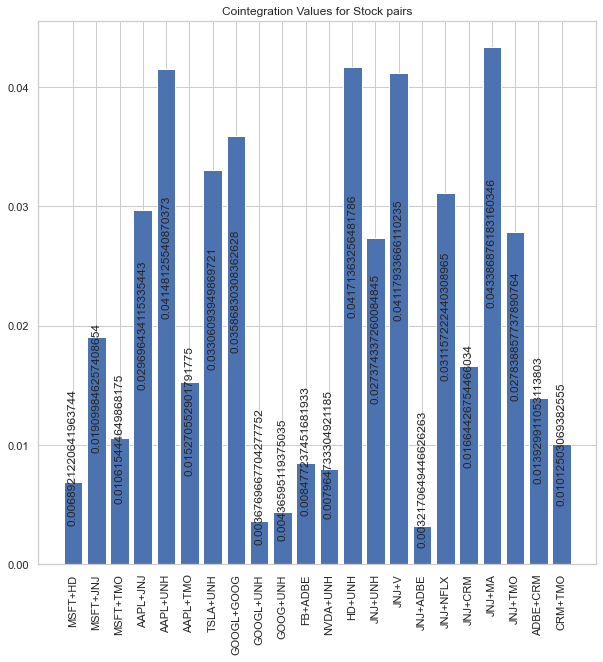

In [19]:
#now calculating the correlation between these stocks. 
#theory - Correleation and cointegration factor

def find_cointegrated_pairs(input_data):
    n = input_data.shape[1]
    score_matrix = np.zeros((n, n))
    coint_value_matrix = np.ones((n, n))
    keys = input_data.keys()
    pairs = []
    dict_pairs = {}
    for i in range(n):
        for j in range(i+1, n):
            df_1 = input_data[keys[i]]
            df_2 = input_data[keys[j]]
            result = coint(df_1, df_2)
            corr_result = np.corrcoef(df_1,df_2)
            score = result[0]
            coint_value = result[1]
            score_matrix[i, j] = score
            coint_value_matrix[i, j] = coint_value
            if coint_value < 0.05:
                pairs.append((keys[i], keys[j]))
                dict_pairs[keys[i]+'+'+keys[j]] = coint_value
    return score_matrix, coint_value_matrix, pairs,dict_pairs

scores, rho_val, pairs,val_dict = find_cointegrated_pairs(prices)

def label_values(x,y):
    for i in range(1,len(x)+1):
        plt.text(i-1,y[i-1]/2,y[i-1],ha='center',rotation='vertical')

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Cointegration Values for Stock pairs',loc='center',)
plt.bar(range(len(val_dict)),list(val_dict.values()),align='center')
plt.xticks(range(len(val_dict)),list(val_dict.keys()),rotation='vertical')
label_values(list(val_dict.keys()),list(val_dict.values()))


min_pair = min(val_dict,key=val_dict.get)
print(min_pair)
s1 = prices['JNJ']
s2 = prices['ADBE']
score,rho_val,_=coint(s1,s2)
score_1 = np.corrcoef(s1,s2)
print(score_1)
print(rho_val)



The above calculation shows the JNJ+ADBE frame has the least cointegration value. We have verified the correlation and the cointegration, so we will proceed with working on the trading strategy with this pair. 

JNJ- Johnson & Johnson ( Pharmaceuticals and Medical Technology)
ADBE - Adobe (Technology)

Traditionally, pairs trading involves selecting stocks which have some degree of relationship with each, generally the intersection of their sectors or business areas. For the course of this trading exercise, we will be looking at cross sector pairs who we have deduced to have a relation simply by studying their data. 

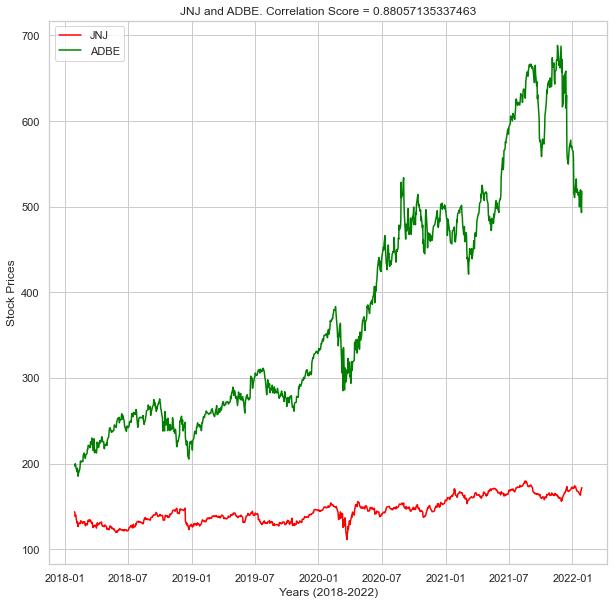

In [20]:
#plotting the stocks
fig, ax = plt.subplots(figsize=(10,10))
#ax.set_title('JNJ and ADBE. Correlation Score',loc='center',)

plt.plot(prices['JNJ'],color = 'red')
plt.plot(prices['ADBE'],color = 'green')
ax.set_xlabel('Years (2018-2022)')
ax.set_ylabel('Stock Prices')


stock_1 = prices['JNJ']
stock_2 = prices['ADBE']
correlation_score = np.corrcoef(stock_1,stock_2)
x = correlation_score[1][0]
#print(correlation_score[1][0])
ax.set_title('JNJ and ADBE. Correlation Score = {}'.format(x),loc='center',)
plt.legend(['JNJ','ADBE'])







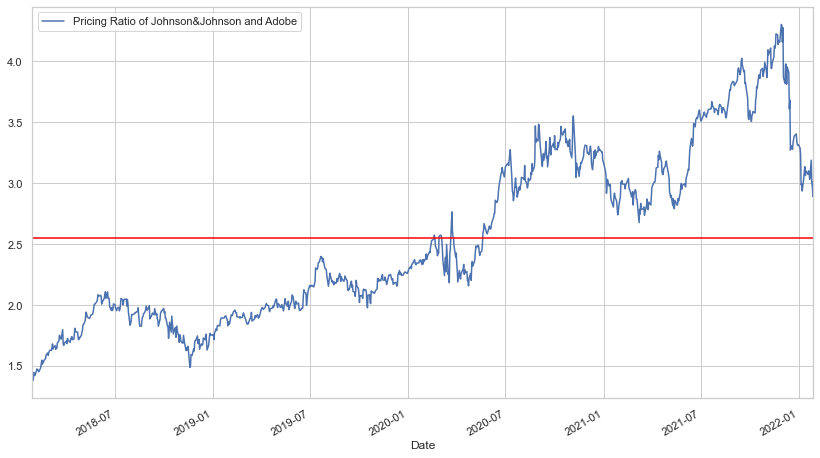

In [21]:
#calculating the spread for the two securties. 
ratio = s2/s1
ratio.plot(figsize = (14,8))
plt.axhline(ratio.mean(),color='red')
plt.xlim('2018-01-28','2022-01-28')
plt.legend(['Pricing Ratio of Johnson&Johnson and Adobe'])

After calculating and constructing our ratio plot, we need to standardize this ratio in order to analyze it better. For this, we introduce the Z-Score. Morever, the spread standardization ensures that we are able to observe whether pairs trading will be successful or not with the given pair of stocks. 

Z-score is the number of standard deviations of a point of data rom the mean. 

Another solutiong invovles calculating the standard deviation and running it over the dataset in order to standardize it, helping normalize the signals. 

As shown below, this standardization has helped limit our observational data, showing the reversion trend better. When making a trade, these normalized values provide better statistical interpretations as compared to raw data values. 

Ratio is increasing at an exponential scale, thus the range is also expected to grow across time. Normalization should ideally account for this, which is why new_zscore function uses the rolling window and constructs a moving z score. 

zscore() is the traditional calculation, while new_zscore() is the moving average based calculation. The window needs to be adjusted according to trading period considered. 

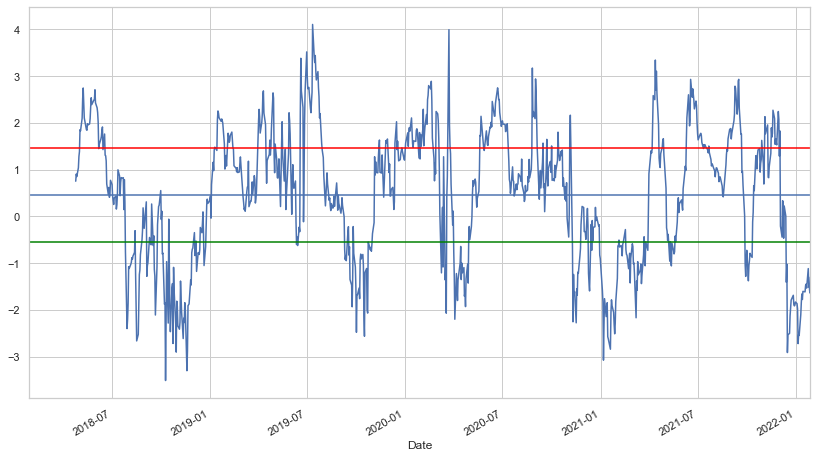

In [22]:
def zscore(data_s):
    return (data_s - data_s.mean()) / np.std(data_s)

def new_zscore(data_s):
    r = data_s.rolling(window=60)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (data_s-m)/s
    return z


#zscore(ratio).plot(figsize=(14,8))
x = new_zscore(ratio).mean()
new_zscore(ratio).plot(figsize=(14,8))
plt.axhline((new_zscore(ratio).mean()))
plt.axhline(x+1.0, color='red')
plt.axhline(x-1.0, color='green')
plt.xlim('2018-01-28', '2022-01-28')
plt.show()

We can observe that this standardised score indeeds moves around our mean, moving to highs and lows and then reverting to the mean values. We have not completely adjusted the range but the oscillating behaviour is visible.

For the Trading model, we follow the 70-30 split, i.e, 70% of the data is used for training and 30% is used for testing the model. A simple way of splitting the datasets is by taking their ratio and multiplying it 0.7.

In [23]:
ratios = prices['ADBE'] / prices['JNJ'] 
print(len(ratios) * .70 ) 


706.3


In [24]:
training_set = ratios[:706]
testing_set = ratios[706:]

# Model Construction

For constructing the sample model, we need to utilize moving averages, standard deviations and z-scores. The key is that ratio's always eventually revert back to mean. 

Like the SMA strategy, we set up two moving averages, a longer period and a shorter period. The longer period is set to 60 days, while the shorted period is set to 5 day. This number can also be 400/100, 100/20 , 50/10 etc. The moving zscore has been calculated along with the implementation of the traditional zscore. 

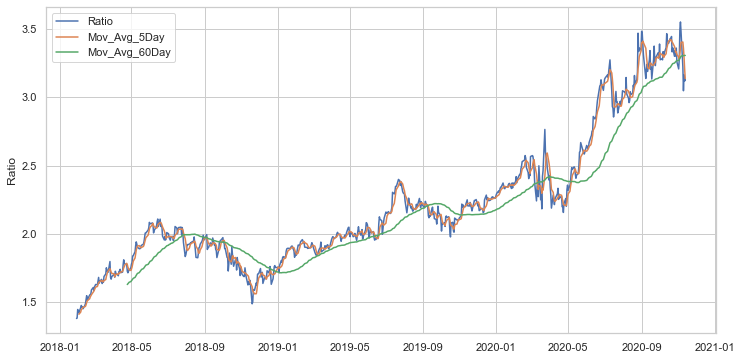

In [39]:
moving_average_5_day = training_set.rolling(window=5).mean()
moving_average_60_day = training_set.rolling(window=60).mean()
standard_dev_60 = training_set.rolling(window=60).std()
z_score_moving = (moving_average_5_day - moving_average_60_day)/standard_dev_60




def moving_average_visualizer(training_set):
    plt.figure(figsize=(12, 6))
    plt.plot(training_set.index, training_set.values)
    plt.plot(moving_average_5_day.index, moving_average_5_day.values)
    plt.plot(moving_average_60_day.index, moving_average_60_day.values)
    plt.legend(['Ratio', 'Mov_Avg_5Day', 'Mov_Avg_60Day'])

    plt.ylabel('Ratio')
    plt.show()

    


moving_average_visualizer(training_set)



The Zscore in our reference varies from -0.54 to +1.46 (approximately). But with tuning and trial-error, we can use a more appropriate set of values. We can use this to generate our buy and sell signals. 
1. We buy whenever the z score goes below -1, because we anticipate the ratio will be increase.
2. We sell whenever the z core goes above 1, becauase we anticipate the ratio will be decreasing. 

In terms of our pair trading and our stock set,
1. When the buy signal is present, we buy stock_1 and sell stock_2.
2. When the sell signal is presented, we sell stock_1 and buy stock_2.

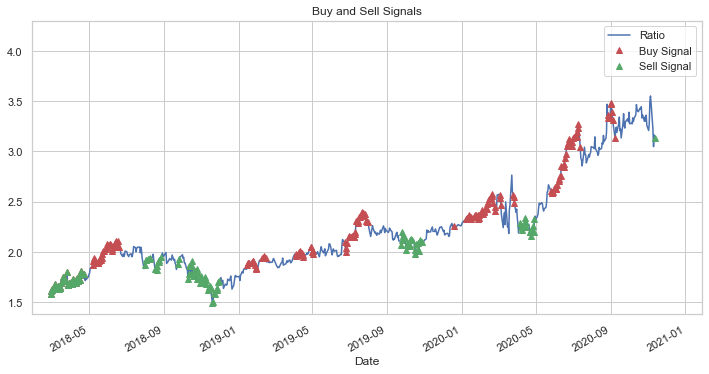

In [37]:
def generate_signals(training_set):
    global z_score_moving
    plt.figure(figsize=(12,6))
    buy = training_set.copy()
    sell = training_set.copy()
    training_set[20:].plot()
    for i in range(len(z_score_moving)):
        if z_score_moving[i] > -1:
            buy[i] = 0
    for i in range(len(z_score_moving)):
        if z_score_moving[i] < 1.4:
            sell[i] = 0
    sell[20:].plot(color='r', linestyle='None', marker='^')
    buy[20:].plot(color='g', linestyle='None', marker='^')
    x1, x2, y1, y2 = plt.axis()
    plt.axis((x1, x2, ratios.min(), ratios.max()))
    plt.xlim('2018-01-28','2021-01-28')
    plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
    plt.title('Buy and Sell Signals')
    plt.show()
    return buy,sell
    
buy,sell = generate_signals(training_set)

# Backtest

Analyzing Profits and losses. We have built our basic model with the ratio of the data, we test it on the remaining part of the dataframe pair. There are no transaction costs considered in this analysis. 
Data up till January 2021 was used in training the model itself. Data used for testing is from February 2021 to January 2022. 

In [40]:
def backtest(asset_1, asset_2, window1, window2):
    profits = 0
    prof_list = []
    loss_list = []
    losses = 0
    if (window1 == 0 or window1 < 0) or (window2 == 0 or window2 < 0):
        print('Observational Periods cannot be 0 or negative')
        return 0
    
    # Compute rolling mean and rolling standard deviation
    spread = asset_2/asset_1
    moving_average_1 = spread.rolling(window=window1,).mean()
    moving_average_2 = spread.rolling(window=window2,).mean()
    standard_deviation = spread.rolling(window=window2,).std()
    z_score_moving = (moving_average_1 - moving_average_2)/standard_deviation
    
    # the starting capital can also be taken to zero to indicate profits made
    capital = 10000
    initial_cap = capital
    capital_list = [10000]
    print("Initial Capital invested = {}".format(capital))
    trades = 0
    count_1 = 0
    count_2 = 0
    for i in range(len(spread)):
        # Sell if the z-score is > 1
        #earlier -0.5385380964626325
        if z_score_moving[i] < -1.3:
            trades += 1
            capital += asset_2[i] - asset_1[i] * spread[i]
            profits += asset_2[i] - asset_1[i] * spread[i]
            prof_list.append(i)
            count_2 -= 1
            count_1 += spread[i]
            capital_list.append(capital)
        # Buy if the z-score is < -1
        #earlier it was 1.4614619035373675
        
        elif z_score_moving[i] > 1.5:

            trades += 1
            losses += asset_2[i] - asset_1[i] * spread[i]
            loss_list.append(i)
            capital -= (asset_2[i] - asset_1[i]*spread[i])
            count_2 += 1
            count_1 -= spread[i]
            capital_list.append(capital)


        # Exit the positions, like the stop loss
        elif abs(z_score_moving[i]) < 5:
            trades +=1 
            capital += asset_2[i] * count_2 + asset_1[i] * count_1
            profits+= asset_2[i] * count_2 + asset_1[i] * count_1
            prof_list.append(i)
            count_1 = 0
            count_2 = 0  
            capital_list.append(capital)
        else:
            pass
    return_list = []

    for i in capital_list:
        return_list.append(i-initial_cap)
    mean = statistics.mean(return_list)
    standard_deviation = statistics.pstdev(return_list)
    sharpe = mean / standard_deviation
    plt.plot(capital_list,label='Equity Line',color='black')
    plt.title('Capital Growth')
    print("Number of trades made = {}".format(trades))
    print("Losses = {}".format(abs(losses)))
    print("Final returns on Capital =  {}".format(capital))
    print("Profits = {}".format(profits))
    print("Return On Investment(%) =  {}".format(((capital-10000)/10000)*100))
    print("Sharpe Ratio =  {}".format(sharpe))   
    return capital



Initial Capital invested = 10000
Number of trades made = 244
Losses = 5.684341886080802e-14
Final returns on Capital =  13500.76730835715
Profits = 3500.76730835715
Return On Investment(%) =  35.0076730835715
Sharpe Ratio =  1.2584584680932673


13500.76730835715

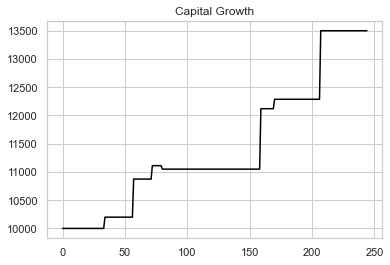

In [41]:
backtest(prices['JNJ'].iloc[706:],prices['ADBE'].iloc[706:],60,5)

## Observation

A stop loss z_score value of 0.75 yields about 7.85% returns on the investment, whereas a z_score of 0.85 yields ~10% returns, with 2 extra trades being executed(241 vs 243). Taking a significantly higher Z score of 5 for exiting positions yeilds in 35% returns.

Tweakng the Z Score parameters (hyperparameter tuning) yields better results with lower loss and higher returns on investment. The losses is minimal in this case owing to the sheer pricing difference in the stocks (ADBE trades for much higher than JNJ in the testing period). The dips as a result are not very noticeable. 

The strategy, if the ratio is reverse and the parameters are re-adjusted takes even riskier trades, with losses amounting to 73627.04663682106 and profits to 83804.65648900282. While the final result is a higher capital growth being observed, with the initial 10000 becoming 20177.60985218175, it presents an extreme level of uncertainity. The short sell in this case takes the risk to the extreme low and only cashing out the longs pulls the capital back into the initial levels. This is not ideal. 